# Plot exoplanet occurrence rate as a function of vertical action.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from detection_efficiency_functions import *
from data_wrangling import *
from plotting import *

from scipy.stats import gamma

from tqdm import tqdm

In [2]:
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

In [25]:
stlr_n = get_catalog("q1_q16_stellar")

# Put in whatever you want here.
adf = pd.read_csv("../ages/stlr_gaia_actions.csv")
stripped_adf = pd.DataFrame(dict({
    #"kepid": adf.kepid.values, "Jz": np.log10(adf.J_z.values)}))  # Put in whatever you want here.
    "kepid": adf.kepid.values, "Jz": np.log10(adf.Z.values)}))  
stlr = pd.merge(stlr_n, stripped_adf, on="kepid")
print(np.shape(stlr))

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

# Lines to change for different stellar parameters.
var_names = ["koi_period", "koi_prad", "teff"]

period_rng = (50, 300)
radius_rng = (0.75, 2.5)
teff_rng = (4200, 6101)
jz_rng = (-10, 10)
#jz_rng = (-1, 5)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


(89536, 100)


89536


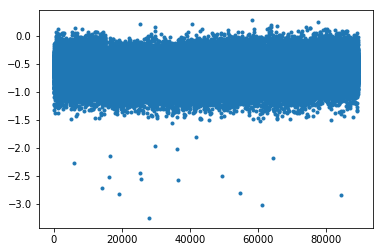

In [26]:
plt.plot(np.arange(len(stlr.Jz)), stlr.Jz, ".")
print(len(stlr.Jz.values))
#print(stlr.Jz.values)

In [27]:
# Select G and K dwarfs.
m = (teff_rng[0] <= stlr.teff) & (stlr.teff <= teff_rng[1])
m = (jz_rng[0] <= stlr.Jz) & (stlr.Jz <= jz_rng[1])
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 85119 targets after cuts


In [28]:
kois = get_catalog("q1_q16_koi")

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid", "Jz"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (radius_rng[0] <= kois.koi_prad) & (kois.koi_prad <= radius_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 143 KOIs after cuts


Load action data and merge with the stlr catalogue.

In [29]:
def get_completeness(star, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
                     mesthres_vals, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param c_grid:    the stellar property grid
    :param c:         the stellar property of this star.
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
                    mesthres_vals)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

In [30]:
N = int(1e5)

In [31]:
np.random.seed(123)
period_samp = np.random.uniform(period_rng[0], period_rng[1], N)
radius_samp = np.random.uniform(radius_rng[0], radius_rng[1], N)

star_ind = np.random.randint(len(stlr), size=N)
jz_samp = stlr.Jz.values[star_ind]

# Assume eccentricity = 0
e = 0

Q_samp = np.empty(N)
for i, (_, star) in tqdm(enumerate(stlr.iterrows()), total=len(stlr)):
    m = star_ind == i
    if not np.any(m):
        continue
    Q_samp[m] = get_completeness(star, period_samp[m], radius_samp[m], e, 
                                 cdpp_cols, cdpp_vals, pgam, mesthres_cols,
                                 mesthres_vals)

100%|██████████| 85119/85119 [02:00<00:00, 708.18it/s]


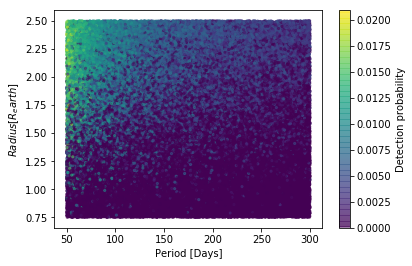

In [32]:
plt.scatter(period_samp, radius_samp, c=Q_samp, s=5, alpha=.5)
plt.xlabel("Period [Days]")
plt.ylabel("$Radius [R_earth]$")
plt.colorbar(label="Detection probability") # Probability of detecting planet at that period and radius

In [33]:
X_samp = np.vstack((period_samp, radius_samp, jz_samp/100)).T  # Now 1 Jz 'unit' is 100 K
bins = [np.linspace(period_rng[0], period_rng[1], 3), 
        np.linspace(radius_rng[0], radius_rng[1], 3),
        np.linspace(jz_rng[0], jz_rng[1], 3)/100]

numerator, _ = np.histogramdd(X_samp, bins, weights=Q_samp)
denominator, _ = np.histogramdd(X_samp, bins)

# Multiply the denom by the observed distribution of Jzs which includes the selection function
# Need to do this for each stellar property.
denominator *= np.histogram(jz_samp/100, bins[2], normed=True)[0][None, None, :]

# broadcast the bin widths over the 8*10*2 grid then take the product to get the volume.
volume = np.prod(np.meshgrid(*map(np.diff, bins), indexing="ij"), axis=0)

numerator *= volume

integrated_det_eff = numerator/denominator

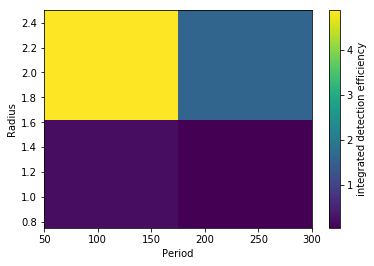

In [34]:
plt.pcolor(bins[0], bins[1], np.sum(integrated_det_eff, axis=2).T)
plt.xlabel("Period")
plt.ylabel("Radius")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

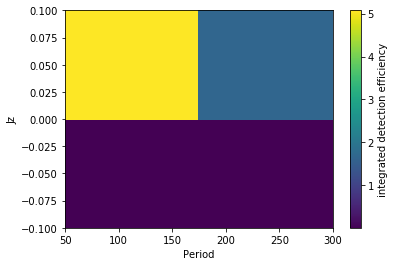

In [35]:
plt.pcolor(bins[0], bins[2], np.sum(integrated_det_eff, axis=1).T)
plt.xlabel("Period")
plt.ylabel("Jz")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

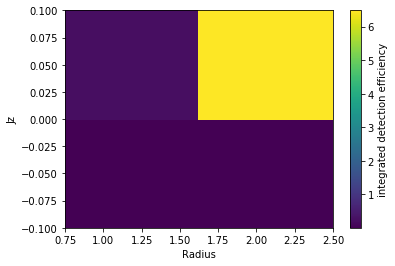

In [36]:
plt.pcolor(bins[1], bins[2], np.sum(integrated_det_eff, axis=0).T)
plt.xlabel("Radius")
plt.ylabel("Jz")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

In [37]:
X = np.vstack((kois.koi_period.values, kois.koi_prad.values, kois.Jz.values/100)).T

In [38]:
hist_of_observed_planets = np.histogramdd(X, bins)[0]
theta = hist_of_observed_planets/integrated_det_eff
theta_var = theta/integrated_det_eff
theta.shape

(2, 2, 2)

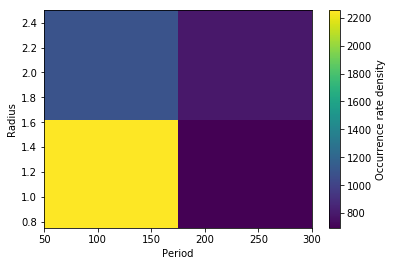

In [39]:
plt.pcolor(bins[0], bins[1], np.sum(np.diff(bins[2])[None, None, :]*theta, axis=2).T)
plt.xlabel("Period")
plt.ylabel("Radius")
plt.colorbar(label="Occurrence rate density")  # integrated over the bin

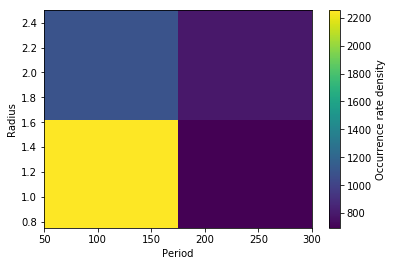

In [40]:
plt.pcolor(bins[0], bins[1], np.sum(np.diff(bins[2])[None, None, :]*theta, axis=2).T)
plt.xlabel("Period")
plt.ylabel("Radius")
plt.colorbar(label="Occurrence rate density")  # integrated over the bin

Text(0.5,0,'Radius')

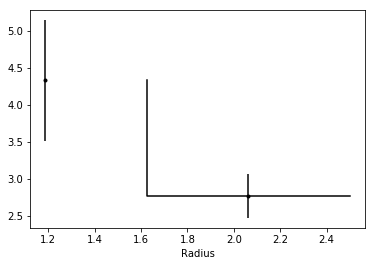

In [41]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[0], bins[2]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[:, None, :]*theta, axis=(0, 2))
err = (np.sum(marg_volume[:, None, :]**2*theta_var, axis=(0, 2)))**.5
plt.step(bins[1][1:], occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[1][:-1] + bins[1][1:]), occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Radius")

Text(0.5,0,'Period')

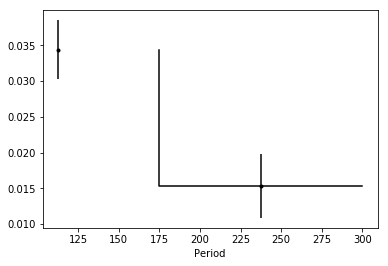

In [42]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[1], bins[2]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[None, :, :]*theta, axis=(1, 2))
err = np.sqrt(np.sum(marg_volume[None, :, :]**2*theta_var, axis=(1, 2)))
plt.step(bins[0][1:], occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[0][:-1] + bins[0][1:]), occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Period")

Text(0.5,0,'Jz')

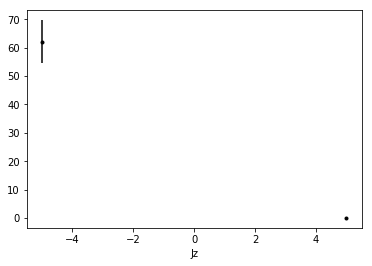

In [43]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[0], bins[1]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[:, :, None]*theta, axis=(0, 1))
err = np.sqrt(np.sum(marg_volume[:, :, None]**2*theta_var, axis=(0, 1)))
# plt.scatter(.5 * (bins[2][:-1] + bins[2][1:])*100, occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[2][:-1] + bins[2][1:])*100, occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Jz")

[-10.   0.  10.]


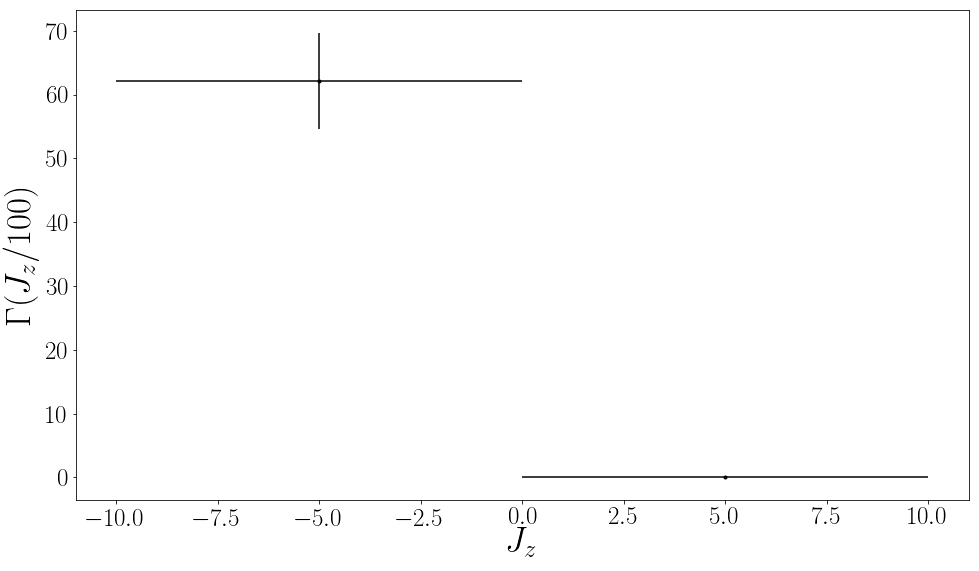

In [44]:
plotpar = {'axes.labelsize': 35,
           'font.size': 35,
           'legend.fontsize': 35,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
pl.rcParams.update(plotpar)

fig = plt.figure(figsize=(16, 9))
x = .5 * (bins[2][:-1] + bins[2][1:])*100
xerrm = np.array([x[0] - bins[2][0]*100, x[1] - bins[2][1]*100])
xerrp = np.array([bins[2][1]*100 - x[0], bins[2][2]*100 - x[1]])
print(bins[2]*100)
plt.errorbar(x, occ/len(stlr), xerr=(xerrm, xerrp), 
             yerr=err/len(stlr), fmt="k.")
plt.xlabel("$J_z$")
plt.ylabel("$\\Gamma(J_z/100)$")
#plt.xlim(4150, 6150)
plt.savefig("Jz_occ_rate")

In [163]:
print(occ/len(stlr))

[842.39684407   2.05789057]


What if you're just missing the systems with astrometric planets?
- but you would be missing all these planets, not just the detections.

Does metallicity follow this same trend?
What happens if you don't do cuts on parallax error?
What do you see if you use height above the plane?